In [1]:
import torchvision.transforms as tf
import torchvision.transforms.functional as TF
import sys
sys.path.append("../")
import gc
import numpy as np
import scanpy as sc
import squidpy as sq
import tqdm
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from Models.DeepPT import augment as aug_
from Dataloader.Dataset import *
        

Dataset path: /afm01/UQ/Q2051


In [2]:
# Color normalization
target = cv2.cvtColor(cv2.imread(f"../Dataset/Reference_Normalization/ref_HE.png"), cv2.COLOR_BGR2RGB)
def color_normalization(img, target, method="macenko"):
    """
    img: numpy array, RGB image
    method: str, "raw", "macenko" or "reinhard"
    target: numpy array, RGB image
    """

    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Lambda(lambda x: x*255)
    ])
    if method == "macenko":
        Normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img, Macenko_H, Macenko_E = Normalizer.normalize(I=T(img), stains=True)
    elif method == "reinhard":
        Normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img = Normalizer.normalize(I=T(img))
    elif method == "raw":
        img = img
    return img

def aug(image, trans):
    # Randomly select one augmentation
    selected_augmentation = trans

    # Apply the selected augmentation
    if selected_augmentation == "blur":
        # Gassian blur
        image = tf.GaussianBlur(kernel_size=7, sigma=(1, 1.5))(image)

    elif selected_augmentation == "random_grayscale":
        # Random grayscale
        image = tf.RandomGrayscale(1.0)(image)
        
    elif selected_augmentation == "random_rotation":
        # Random flipping and rotations
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([180, 90, 0, -90]))
    elif selected_augmentation == "reinhard":
        # Color normalization
        image = torch.tensor(color_normalization(image.permute(1,2,0).numpy(), target, method="reinhard")).permute(2,0,1)

    elif selected_augmentation == "none":
        # No augmentation
        pass
    return image

In [3]:
dataset_name = "Skin_cSCC"
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_{dataset_name}.npy", allow_pickle=True)
te_data = CSCC(train=False, fold=1, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", exp_norm="log1p",
                            gene_list=target_gene_list)

['P2_ST_rep2']
Loading imgs...


100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


Loading metadata...


100%|██████████| 1/1 [00:11<00:00, 11.81s/it]


subset_size: 646
Loading gene expression
Croping WSI into patches...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


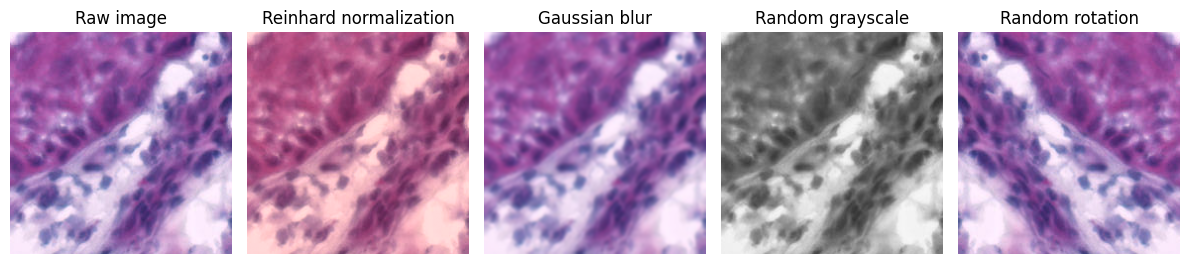

In [9]:
import matplotlib.pyplot as plt
import numpy as np

img = te_data[0][0][15]
trans = ["none", "reinhard", "blur", "random_grayscale", "random_rotation" ]

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

# Iterate over transformations
for i, tran in enumerate(trans):
    aug_img = aug(img, tran).cpu().numpy()

    if len(aug_img.shape) == 4:
        aug_img = aug_img.squeeze(0).transpose(1, 2, 0) / 255
    else:
        aug_img = aug_img.transpose(1, 2, 0) / 255.0
    
    if tran == "blur":
        tran = "Gaussian blur"
    elif tran == "random_grayscale":
        tran = "Random grayscale"
    elif tran == "random_rotation":
        tran = "Random rotation"
    elif tran == "reinhard":
        tran = "Reinhard normalization"
    elif tran == "template":
        tran = "Template"
    elif tran == "none":
        tran = "Raw image"

    # Plot each augmented image
    axes[i].imshow(aug_img)
    axes[i].set_title(tran)
    axes[i].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect parameter to leave space for the common title

# Show the plot
plt.show()


# Visual gene expression

In [7]:
import sys
sys.path.append("../")
from Dataloader.Dataset import *
import gc
import numpy as np
import scanpy as sc
import squidpy as sq
import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
adatas = []
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_{dataset_name}.npy", allow_pickle=True)
for i in range(11):
    gc.collect()
    target_gene_list = ['NOG']
    te_data = CSCC(train=False, fold=i, r=112, num_subsets=1,
                    neighs=4, color_norm="raw", exp_norm="raw",
                    gene_list=target_gene_list)
    adata_dict = te_data.meta_dict
    adatas.append(adata_dict[list(adata_dict.keys())[0]])

In [9]:
adata_cat = ad.concat(adatas).copy()

In [11]:
exp = adata_cat.to_df()

In [13]:
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy", allow_pickle=True)

In [16]:
def expression_normalization(exp, exp_norm):
    if exp_norm == "raw":
        exp_new = exp[target_gene_list].values.astype(np.float64) 
    elif exp_norm == "lognorm":
        exp_new = scp.transform.log(scp.normalize.library_size_normalize(exp[target_gene_list].values)).astype(np.float64)
    elif exp_norm == "norm":
        exp_new = scp.normalize.library_size_normalize(exp[target_gene_list].values).astype(np.float64)
    elif exp_norm == "log1p":
        exp_new = scp.transform.log(exp[target_gene_list].values).astype(np.float64)
    elif exp_norm == "minmax":
        exp_new = MinMaxScaler().fit_transform(exp[target_gene_list].values).astype(np.float64)
    return exp_new



In [59]:
target_gene_list = ["PFN1"]
exp_raw = expression_normalization(exp, "raw")
exp_norm = expression_normalization(exp, "norm")
exp_log = expression_normalization(exp, "log1p")
exp_lognorm = expression_normalization(exp, "lognorm")
exp_minmax = expression_normalization(exp, "minmax")


In [71]:
x = pd.DataFrame(exp_raw, columns=['Raw'])
x["Norm"] = exp_norm
x["Log1p"] = exp_log
x["LogNorm"] = exp_lognorm
x["MinMax"] = exp_minmax

In [85]:
x

,Raw,Norm,Log1p,LogNorm,MinMax
0,3.0,10000.0,0.602060,4.000043,0.015707
1,7.0,10000.0,0.903090,4.000043,0.036649
2,30.0,10000.0,1.491362,4.000043,0.157068
3,2.0,10000.0,0.477121,4.000043,0.010471
4,25.0,10000.0,1.414973,4.000043,0.130890
...,...,...,...,...,...
8204,6.0,10000.0,0.845098,4.000043,0.031414
8205,2.0,10000.0,0.477121,4.000043,0.010471
8206,11.0,10000.0,1.079181,4.000043,0.057592
8207,37.0,10000.0,1.579784,4.000043,0.193717


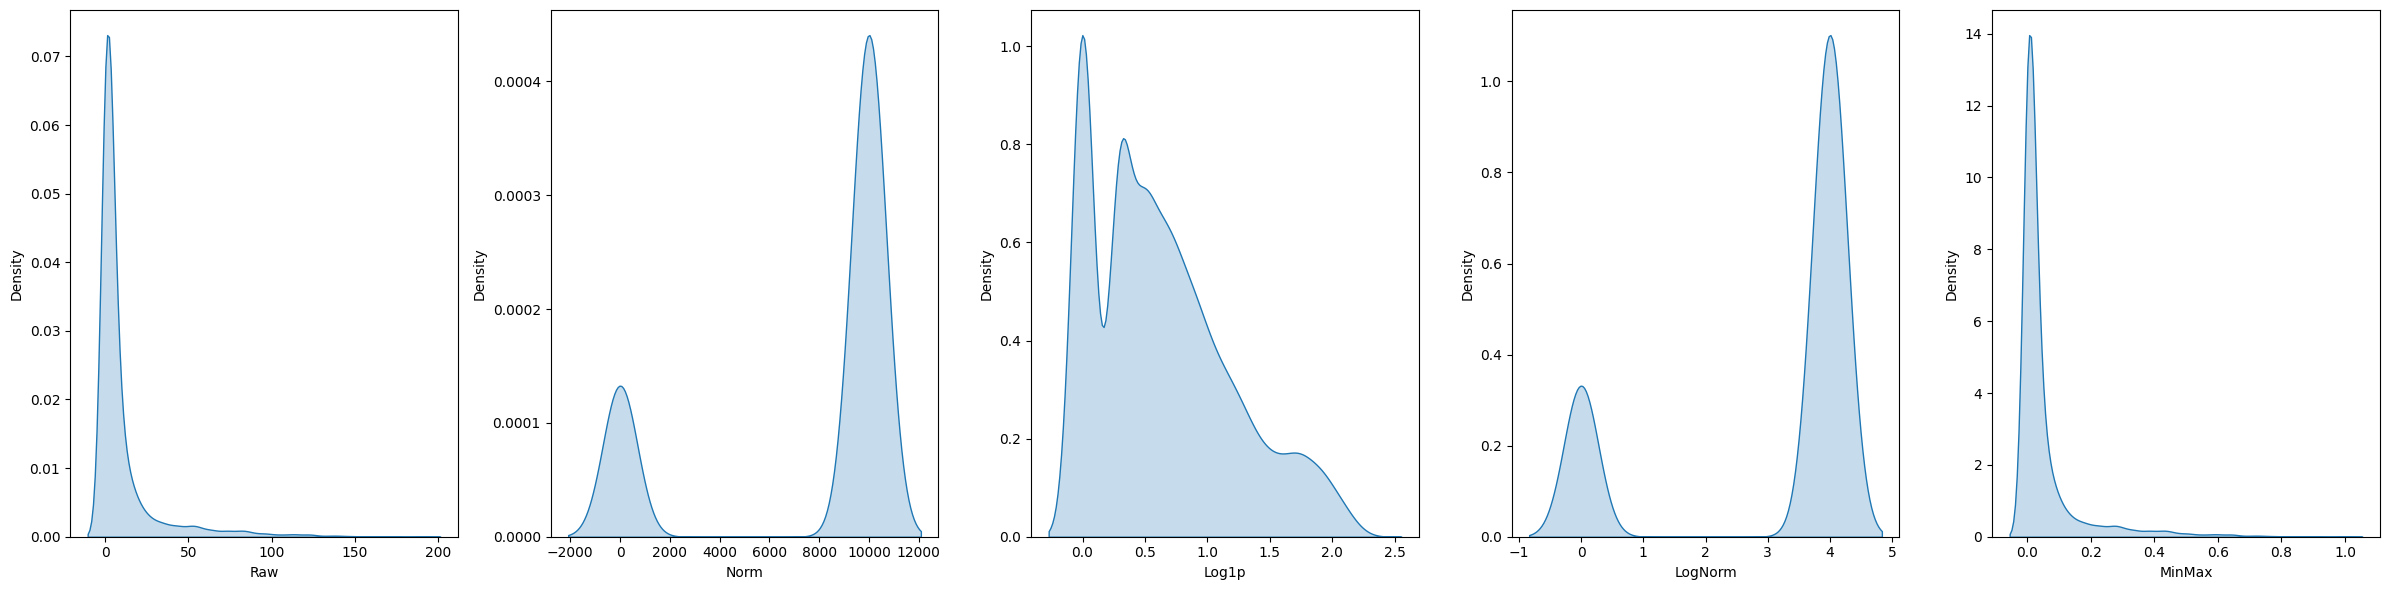

In [79]:
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(24, 6))
methods  = ['Raw', 'Norm', 'Log1p', 'LogNorm', 'MinMax']
for i in range(5):
    method = methods[i]
    sns.kdeplot(data=x[method], common_norm=False, fill=True, ax=axes[i])

plt.tight_layout()
plt.show()


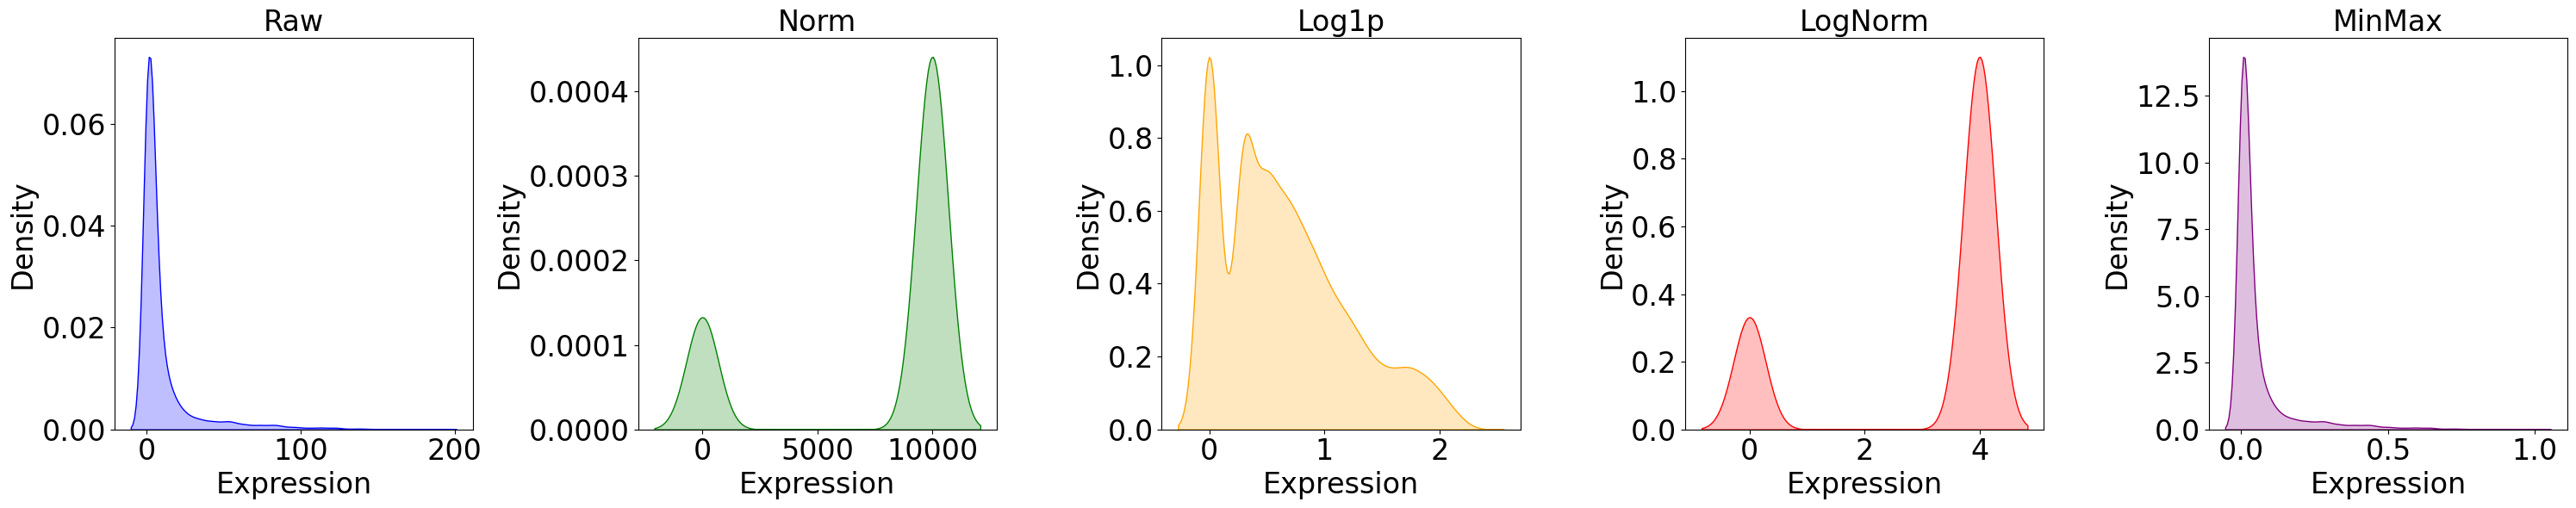

In [86]:
import seaborn as sns

# Create a 1x5 subplot grid with a larger overall figure size
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

# List of methods and corresponding colors
methods = ['Raw', 'Norm', 'Log1p', 'LogNorm', 'MinMax']
colors = ['blue', 'green', 'orange', 'red', 'purple']

# Iterate over methods
for i, method in enumerate(methods):
    # Specify color for each method
    sns.kdeplot(data=x[method], common_norm=False, fill=True, ax=axes[i], color=colors[i])

    # Set titles and labels
    axes[i].set_title(method, fontsize=24)
    axes[i].set_xlabel('Expression', fontsize=24)
    axes[i].set_ylabel('Density', fontsize=24)

    # Customize tick labels
    axes[i].tick_params(axis='both', which='both', labelsize=24)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [12]:
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F

# Function to generate random graph
def generate_random_graph(num_nodes, edge_prob):
    G = nx.gnp_random_graph(num_nodes, edge_prob)
    adjacency_matrix = nx.to_numpy_array(G)
    return adjacency_matrix

# Function to compute contrastive loss
def mi_loss_jsd(pos, neg):
    e_pos = torch.mean(F.logsigmoid(-pos))
    e_neg = torch.mean(torch.mean(F.logsigmoid(neg), dim=0))
    return e_pos + e_neg

# Function to compute reconstruct loss
def reconstruct_loss(pre, gnd):
    nodes_n = gnd.shape[0]
    edges_n = torch.sum(gnd) / 2
    weight1 = (nodes_n * nodes_n - edges_n) * 1.0 / edges_n
    weight2 = nodes_n * nodes_n * 1.0 / (nodes_n * nodes_n - edges_n)
    gnd = torch.FloatTensor(gnd)
    temp1 = gnd * torch.log(pre + (1e-10)) * (-weight1)
    temp2 = (1 - gnd) * torch.log(1 - pre + (1e-10))
    return torch.mean(temp1 - temp2) * weight2

# Generate two random graphs
num_nodes = 10
edge_prob = 0.3
graph1 = generate_random_graph(num_nodes, edge_prob)
graph2 = generate_random_graph(num_nodes, edge_prob)

# Convert adjacency matrices to PyTorch tensors
graph1_tensor = torch.FloatTensor(graph1)
graph2_tensor = torch.FloatTensor(graph2)

# Compute embeddings (replace this with your actual embedding computation)
embedding1 = torch.randn(num_nodes, 64)
embedding2 = torch.randn(num_nodes, 64)

# Compute losses
positive_pairs = torch.matmul(embedding1, embedding1.t())
negative_pairs = torch.matmul(embedding1, embedding2.t())

loss_mi_jsd = mi_loss_jsd(positive_pairs, negative_pairs)
loss_reconstruct = reconstruct_loss(torch.sigmoid(torch.matmul(embedding1, embedding1.t())), graph1_tensor)

print("Contrastive Loss (MI with JSD):", loss_mi_jsd.item())
print("Reconstruct Loss:", loss_reconstruct.item())


Contrastive Loss (MI with JSD): -12.172511100769043
Reconstruct Loss: 10.99676513671875


In [13]:
graph1_tensor.shape

torch.Size([10, 10])

In [14]:
embedding1.shape

torch.Size([10, 64])

In [15]:
positive_pairs.shape

torch.Size([10, 10])

In [16]:
import numpy as np

def adjacency_to_transition(adjacency_matrix):
    row_sums = np.sum(adjacency_matrix, axis=1, keepdims=True)
    transition_matrix = adjacency_matrix / row_sums
    return transition_matrix

# Example usage:
adjacency_matrix = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

transition_matrix = adjacency_to_transition(adjacency_matrix)
print("Adjacency Matrix:")
print(adjacency_matrix)
print("\nTransition Matrix:")
print(transition_matrix)


Adjacency Matrix:
[[0 1 0]
 [1 0 1]
 [0 1 0]]

Transition Matrix:
[[0.  1.  0. ]
 [0.5 0.  0.5]
 [0.  1.  0. ]]


In [19]:
import torchvision

backbone = torchvision.models.resnet50(pretrained=True)
backbone.fc = torch.nn.Identity()
backbone

/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

torch.Size([1, 2048])